# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to infoine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio = portfolio.rename(columns={'id': 'offer_id'})
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
# dataset to append back to original
df_channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)

In [5]:
df_channels

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [6]:
df_portfolio = pd.concat([portfolio, df_channels], axis=1).drop(['channels'], axis=1)

There are 10 unique offer ids

In [7]:
# checking unique values of offer_type
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

We can definitely do some data cleaning here. If age = 118, gender = None, and income = NaN we should remove the row. 

In [8]:
profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [9]:
# data cleaning: remove age=118
profile_new = profile[(profile.age != 118)]
outliers = profile[(profile.age == 118)]

In [10]:
list(outliers['id'])

['68be06ca386d4c31939f3a4f0e3dd783',
 '38fe809add3b4fcf9315a9694bb96ff5',
 'a03223e636434f42ac4c3df47e8bac43',
 '8ec6ce2a7e7949b1bf142def7d0e0586',
 '68617ca6246f4fbc85e91a2a49552598',
 '8974fc5686fe429db53ddde067b88302',
 'c4863c7985cf408faee930f111475da3',
 '148adfcaa27d485b82f323aaaad036bd',
 '744d603ef08c4f33af5a61c8c7628d1c',
 '2b826eba31074a059d63b0ae8f50b7d5',
 '65aba5c617294649aeb624da249e1ee5',
 '4beeb3ed64dd4898b0edf2f6b67426d3',
 '25c906289d154b66bf579693f89481c9',
 '5b8f1f0e0930464f93bb55e59b5a04e0',
 '8be4463721e14d7fa600686bf8c8b2ed',
 '81ac76e4f2fe4a6bb5ebdc0f19cecc56',
 '020d3a52b9ce432ea5f98fc58e9bfcc4',
 '4be1127413db496d8103c783ae72058b',
 '9d8d6bb2fc544a9c802888971ee3e8b1',
 'a89752cdfdf24779aa22faa2bc24e7c2',
 '53bac762af27471eb294ff89ca1bae2c',
 '488773cae11f4b71875bfccd4e3e99f2',
 '182e68952b474700b171e21b85c258ac',
 '5e9c83e8ab4d4e9ca83f3256d83ca756',
 'c099206f76b1414db7552f163520053c',
 'e6d3eebb535e44aca1323edde5c346fa',
 'baba98dba43e42ae8e86cbd70725e201',
 

In [11]:
# checking unique values of gender
profile_new.gender.unique(), profile_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


(array(['F', 'M', 'O'], dtype=object), None)

In [12]:
# checking profile has 17,000 unique ids as expected
len(profile_new.id.unique())

14825

In [13]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [14]:
# checking if a person can have multiple events. answer is yes
len(transcript.person.unique())

17000

In [15]:
# checking unique values of event
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [16]:
# rename "person" column to "id" so we can join datasets
transcript2 = transcript.rename(columns={'person': 'id'})
transcript3 = transcript2[~transcript2['id'].isin(list(outliers['id']))]

df_info = transcript3.merge(profile_new, on='id', how='left')

In [17]:
# check dataset is infoined correctly
df_info

,event,id,time,value,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,100000.0
1,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},68,20180426,M,70000.0
2,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},65,20180209,M,53000.0
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},58,20171111,M,51000.0
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},61,20170911,F,57000.0
5,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},62,20160211,F,71000.0
6,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},64,20170909,M,100000.0
7,offer received,c27e0d6ab72c455a8bb66d980963de60,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},78,20170616,F,71000.0
8,offer received,d53717f5400c4e84affdaeda9dd926b3,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},88,20170518,F,53000.0
9,offer received,f806632c011441378d4646567f357a21,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},42,20130811,M,69000.0


In [18]:
df_value = df_info['value'].apply(pd.Series)

In [19]:
# dataset to append back to original
df_value

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
2,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
3,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
5,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
6,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN
7,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
9,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN


In [20]:
df_value.isnull().sum()

offer id    156401
amount      148805
offer_id    240318
reward      240318
dtype: int64

In [21]:
df_value['offer id'].count().sum(), df_value['amount'].count().sum(), df_value['offer_id'].count().sum(), df_value['reward'].count().sum()

(116361, 123957, 32444, 32444)

In [22]:
df_value

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
2,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
3,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
5,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
6,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN
7,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
9,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN


In [23]:
# merging the 2 offer id columns into one
offer_id = list(df_value['offer id'].fillna(df_value['offer_id']))

In [24]:
df_value2 = df_value.drop(['offer id','offer_id'], axis=1)

In [25]:
df_value2['offer_id'] = offer_id

In [26]:
df_value2

,amount,reward,offer_id
0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
2,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
3,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
6,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
7,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


In [27]:
# join datasets
df_info2 = pd.concat([df_info, df_value2], axis=1).drop(['value'], axis=1)

In [28]:
# final cleaned and infoined dataset
df_info3 = df_info2.merge(df_portfolio, on='offer_id', how='left')

In [29]:
df_info3

,event,id,time,age,became_member_on,gender,income,amount,reward_x,offer_id,difficulty,duration,offer_type,reward_y,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,75,20170509,F,100000.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,e2127556f4f64592b11af22de27a7932,0,68,20180426,M,70000.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
2,offer received,389bc3fa690240e798340f5a15918d5c,0,65,20180209,M,53000.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,58,20171111,M,51000.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,61,20170911,F,57000.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
5,offer received,31dda685af34476cad5bc968bdb01c53,0,62,20160211,F,71000.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
6,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,64,20170909,M,100000.0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0
7,offer received,c27e0d6ab72c455a8bb66d980963de60,0,78,20170616,F,71000.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
8,offer received,d53717f5400c4e84affdaeda9dd926b3,0,88,20170518,F,53000.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
9,offer received,f806632c011441378d4646567f357a21,0,42,20130811,M,69000.0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0


In [111]:
df_info3.to_csv(r'\df_info3.csv')

In [30]:
# checking to make sure there are no null values
df_info.isnull().values.any()

False

In [31]:
bin_labels_income = ['Low_income', 'Medium_income', 'High_Income', 'Highest_Income']
bin_labels_age = ['young', 'middle_aged', 'old', 'oldest']

df_info3['quartile_income_c'] = pd.qcut(df_info3['income'], q=4, labels=bin_labels_income)
df_info3['quartile_income_n'] = pd.qcut(df_info3['income'], q=4)
df_info3['quartile_age_c'] = pd.qcut(df_info3['age'], q=4, labels=bin_labels_age)
df_info3['quartile_age_n'] = pd.qcut(df_info3['age'], q=4)

In [32]:
df_info3

,event,id,time,age,became_member_on,gender,income,amount,reward_x,offer_id,...,offer_type,reward_y,email,mobile,social,web,quartile_income_c,quartile_income_n,quartile_age_c,quartile_age_n
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,75,20170509,F,100000.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,5.0,1.0,1.0,0.0,1.0,Highest_Income,"(78000.0, 120000.0]",oldest,"(66.0, 101.0]"
1,offer received,e2127556f4f64592b11af22de27a7932,0,68,20180426,M,70000.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,...,discount,2.0,1.0,1.0,0.0,1.0,High_Income,"(62000.0, 78000.0]",oldest,"(66.0, 101.0]"
2,offer received,389bc3fa690240e798340f5a15918d5c,0,65,20180209,M,53000.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,bogo,5.0,1.0,1.0,1.0,1.0,Medium_income,"(48000.0, 62000.0]",old,"(55.0, 66.0]"
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,58,20171111,M,51000.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,...,informational,0.0,1.0,1.0,0.0,1.0,Medium_income,"(48000.0, 62000.0]",old,"(55.0, 66.0]"
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,61,20170911,F,57000.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,discount,5.0,1.0,0.0,0.0,1.0,Medium_income,"(48000.0, 62000.0]",old,"(55.0, 66.0]"
5,offer received,31dda685af34476cad5bc968bdb01c53,0,62,20160211,F,71000.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,discount,5.0,1.0,0.0,0.0,1.0,High_Income,"(62000.0, 78000.0]",old,"(55.0, 66.0]"
6,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,64,20170909,M,100000.0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,...,bogo,10.0,1.0,1.0,1.0,0.0,Highest_Income,"(78000.0, 120000.0]",old,"(55.0, 66.0]"
7,offer received,c27e0d6ab72c455a8bb66d980963de60,0,78,20170616,F,71000.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,...,informational,0.0,1.0,1.0,0.0,1.0,High_Income,"(62000.0, 78000.0]",oldest,"(66.0, 101.0]"
8,offer received,d53717f5400c4e84affdaeda9dd926b3,0,88,20170518,F,53000.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,discount,5.0,1.0,0.0,0.0,1.0,Medium_income,"(48000.0, 62000.0]",oldest,"(66.0, 101.0]"
9,offer received,f806632c011441378d4646567f357a21,0,42,20130811,M,69000.0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,...,discount,2.0,1.0,1.0,1.0,1.0,High_Income,"(62000.0, 78000.0]",middle_aged,"(41.0, 55.0]"


In [33]:
# want to forward fill offer_id for transaction events
df_info4=df_info3.sort_values(['id','time'])
df_info4['offer_id']=df_info4['offer_id'].ffill()
df_info4['offer_type']=df_info4['offer_type'].ffill()

df_info4['offer_response_flag'] = np.where((df_info4['event'].shift() == 'offer viewed') & (df_info4['event'] == 'transaction') & (df_info4['id'].shift() == df_info4['id']),1,0)
df_info4['offer_not_viewed_flag'] = np.where((df_info4['event'].shift() == 'offer received') & (df_info4['event'] == 'transaction') & (df_info4['id'].shift() == df_info4['id']),1,0)

In [46]:
df_comb5 = df_info4[(df_info4['offer_response_flag']==1) | (df_info4['event']=='offer viewed')]

In [32]:
# time range of dataset
df_info3.became_member_on.min(), df_info3.became_member_on.max()

(20130729, 20180726)

(array([  32444.,       0.,       0.,   66501.,       0.,       0.,
          49860.,       0.,       0.,  123957.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

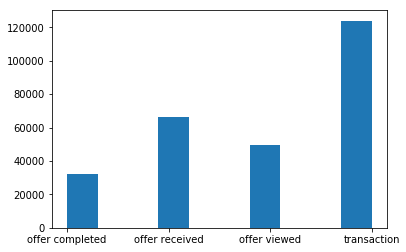

In [33]:
# distribution of offer type data
plt.hist(df_info3['event'])

(array([ 123957.,       0.,       0.,   63834.,       0.,       0.,
          62311.,       0.,       0.,   22660.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <a list of 10 Patch objects>)

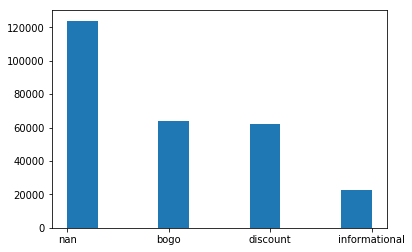

In [34]:
# distribution of event data
plt.hist(df_info3['offer_type'])

(array([ 1169.,  1087.,  1462.,  2338.,  2894.,  2490.,  1890.,   917.,
          446.,   132.]),
 array([  18. ,   26.3,   34.6,   42.9,   51.2,   59.5,   67.8,   76.1,
          84.4,   92.7,  101. ]),
 <a list of 10 Patch objects>)

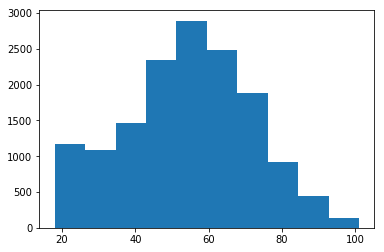

In [35]:
# look at the distributions of customer characteristics 
# age
plt.hist(profile_new['age'])

(array([  274.,   401.,   261.,   392.,  1205.,  1748.,  1276.,  1685.,
         3914.,  3669.]),
 array([ 20130729. ,  20135728.7,  20140728.4,  20145728.1,  20150727.8,
         20155727.5,  20160727.2,  20165726.9,  20170726.6,  20175726.3,
         20180726. ]),
 <a list of 10 Patch objects>)

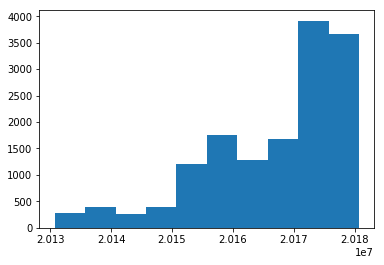

In [36]:
# became_member_on
plt.hist(profile_new['became_member_on'])

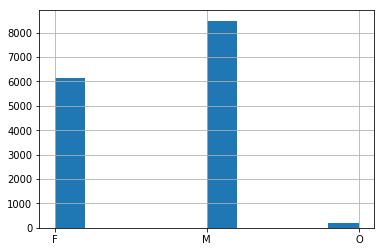

In [37]:
# gender
profile_new.gender.hist();

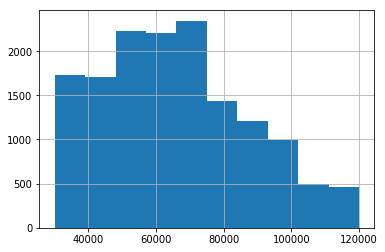

In [38]:
# income
profile_new.income.hist();

# BOGO

In [107]:
df_comb_bogo =df_comb5[(df_comb5.offer_type == 'bogo')]
df_comb_bogo.shape

(38593, 24)

In [108]:
df_comb_bogo

,event,id,time,age,became_member_on,gender,income,amount,reward_x,offer_id,...,email,mobile,social,web,quartile_income_c,quartile_income_n,quartile_age_c,quartile_age_n,offer_response_flag,offer_not_viewed_flag
166743,offer viewed,0009655768c64bdeb2e877511632db8f,456,33,20170421,M,72000.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,1.0,1.0,1.0,1.0,High_Income,"(62000.0, 78000.0]",young,"(17.999, 41.0]",0,0
197805,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,516,40,20180109,O,57000.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,1.0,1.0,0.0,1.0,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",0,0
230079,transaction,0011e0d4e6b944f998e987f904e8c1e5,576,40,20180109,O,57000.0,22.05,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,NaN,NaN,NaN,NaN,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",1,0
155212,offer viewed,0020c2b971eb4e9188eac86d93036a77,426,59,20160304,F,90000.0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,...,1.0,1.0,1.0,1.0,Highest_Income,"(78000.0, 120000.0]",old,"(55.0, 66.0]",0,0
116787,offer viewed,0020ccbbb6d84e358d3414a3ff76cffd,348,24,20161111,F,60000.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,1.0,1.0,1.0,1.0,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",0,0
126697,transaction,0020ccbbb6d84e358d3414a3ff76cffd,378,24,20161111,F,60000.0,14.53,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,NaN,NaN,NaN,NaN,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",1,0
234356,offer viewed,0020ccbbb6d84e358d3414a3ff76cffd,582,24,20161111,F,60000.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,1.0,1.0,0.0,1.0,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",0,0
242692,transaction,0020ccbbb6d84e358d3414a3ff76cffd,600,24,20161111,F,60000.0,10.32,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,NaN,NaN,NaN,NaN,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",1,0
194850,offer viewed,004b041fbfe44859945daa2c7f79ee64,510,55,20180508,F,74000.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,1.0,1.0,1.0,1.0,High_Income,"(62000.0, 78000.0]",middle_aged,"(41.0, 55.0]",0,0
205327,transaction,004b041fbfe44859945daa2c7f79ee64,534,55,20180508,F,74000.0,27.92,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,NaN,NaN,NaN,NaN,High_Income,"(62000.0, 78000.0]",middle_aged,"(41.0, 55.0]",1,0


In [109]:
# the count of offers viewed and offers completed
len(df_comb_bogo[(df_comb_bogo.event =='offer received')]), len(df_comb_bogo[(df_comb_bogo.event =='offer viewed')]), len(df_comb_bogo[(df_comb_bogo.event =='transaction')])

(0, 22039, 16554)

# Distributions Overall for BOGO

((array([ 6067.,     0.,     0.,  5355.,     0.,     0.,  5465.,     0.,
             0.,  5152.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 4509.,     0.,     0.,  3856.,     0.,     0.,  3984.,     0.,
             0.,  4205.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

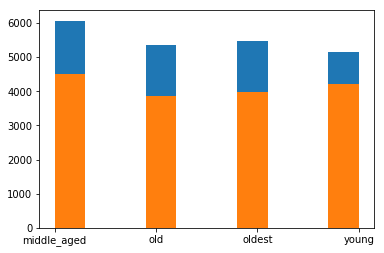

In [110]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_bogo[(df_comb_bogo.event =='offer viewed')]['quartile_age_c']), plt.hist(df_comb_bogo[(df_comb_bogo.event =='transaction')]['quartile_age_c'])

((array([  9143.,      0.,      0.,      0.,      0.,  12581.,      0.,
              0.,      0.,    315.]),
  array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
  <a list of 10 Patch objects>),
 (array([ 6803.,     0.,     0.,     0.,     0.,  9509.,     0.,     0.,
             0.,   242.]),
  array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
  <a list of 10 Patch objects>))

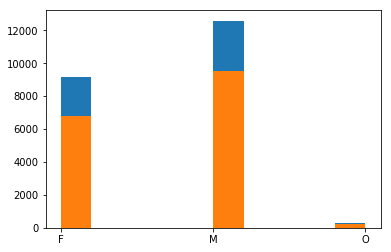

In [111]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_bogo[(df_comb_bogo.event =='offer viewed')]['gender']), plt.hist(df_comb_bogo[(df_comb_bogo.event =='transaction')]['gender'])

((array([ 5662.,     0.,     0.,  5739.,     0.,     0.,  5204.,     0.,
             0.,  5434.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 4176.,     0.,     0.,  3911.,     0.,     0.,  4276.,     0.,
             0.,  4191.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

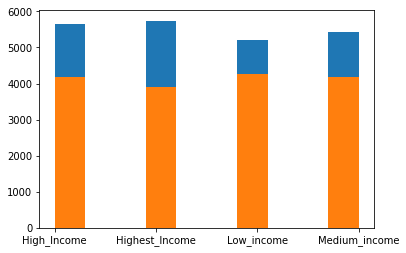

In [112]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_bogo[(df_comb_bogo.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_bogo[(df_comb_bogo.event =='transaction')]['quartile_income_c'])

In [113]:
# create 8 datasets for each group of individuals
df_comb_male_young = df_comb_bogo[(df_comb_bogo['gender']=='M') & (df_comb_bogo['quartile_age_c']=='young')]
df_comb_male_middle = df_comb_bogo[(df_comb_bogo['gender']=='M') & (df_comb_bogo['quartile_age_c']=='middle_aged')]
df_comb_male_old = df_comb_bogo[(df_comb_bogo['gender']=='M') & (df_comb_bogo['quartile_age_c']=='old')]
df_comb_male_oldest = df_comb_bogo[(df_comb_bogo['gender']=='M') & (df_comb_bogo['quartile_age_c']=='oldest')]

df_comb_female_young = df_comb_bogo[(df_comb_bogo['gender']=='F') & (df_comb_bogo['quartile_age_c']=='young')]
df_comb_female_middle = df_comb_bogo[(df_comb_bogo['gender']=='F') & (df_comb_bogo['quartile_age_c']=='middle_aged')]
df_comb_female_old = df_comb_bogo[(df_comb_bogo['gender']=='F') & (df_comb_bogo['quartile_age_c']=='old')]
df_comb_female_oldest = df_comb_bogo[(df_comb_bogo['gender']=='F') & (df_comb_bogo['quartile_age_c']=='oldest')]

# Distributions by Male

((array([  820.,     0.,     0.,   137.,     0.,     0.,  1461.,     0.,
             0.,  1044.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([  647.,     0.,     0.,    89.,     0.,     0.,  1191.,     0.,
             0.,   860.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

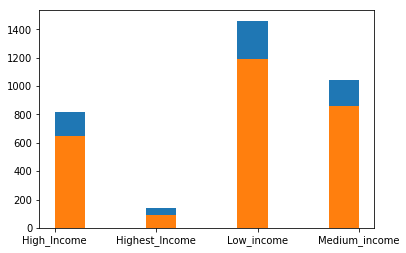

In [114]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_male_young[(df_comb_male_young.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_male_young[(df_comb_male_young.event =='transaction')]['quartile_income_c'])

In [115]:
print("male young")
df_comb_male_young[(df_comb_male_young.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_comb_male_young[(df_comb_male_young.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male young


quartile_income_c
Low_income        0.815195
Medium_income     0.823755
High_Income       0.789024
Highest_Income    0.649635
Name: quartile_income_c, dtype: float64

((array([ 978.,    0.,    0.,  764.,    0.,    0.,  884.,    0.,    0.,  922.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 732.,    0.,    0.,  507.,    0.,    0.,  718.,    0.,    0.,  685.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

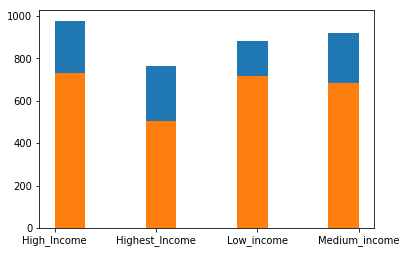

In [116]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_male_middle[(df_comb_male_middle.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_male_middle[(df_comb_male_middle.event =='transaction')]['quartile_income_c'])

In [117]:
print("male middle")
df_comb_male_middle[(df_comb_male_middle.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_comb_male_middle[(df_comb_male_middle.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male middle


quartile_income_c
Low_income        0.812217
Medium_income     0.742950
High_Income       0.748466
Highest_Income    0.663613
Name: quartile_income_c, dtype: float64

((array([ 780.,    0.,    0.,  770.,    0.,    0.,  667.,    0.,    0.,  697.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 543.,    0.,    0.,  513.,    0.,    0.,  549.,    0.,    0.,  507.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

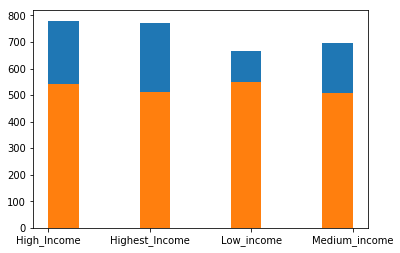

In [118]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_male_old[(df_comb_male_old.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_male_old[(df_comb_male_old.event =='transaction')]['quartile_income_c'])

In [119]:
print("male old")
df_comb_male_old[(df_comb_male_old.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_comb_male_old[(df_comb_male_old.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male old


quartile_income_c
Low_income        0.823088
Medium_income     0.727403
High_Income       0.696154
Highest_Income    0.666234
Name: quartile_income_c, dtype: float64

((array([ 646.,    0.,    0.,  718.,    0.,    0.,  607.,    0.,    0.,  686.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 473.,    0.,    0.,  501.,    0.,    0.,  488.,    0.,    0.,  506.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

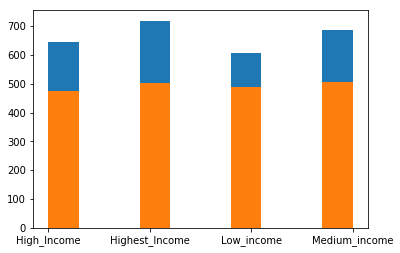

In [120]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_male_oldest[(df_comb_male_oldest.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_male_oldest[(df_comb_male_oldest.event =='transaction')]['quartile_income_c'])

In [121]:
print("male oldest")
df_comb_male_oldest[(df_comb_male_oldest.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_comb_male_oldest[(df_comb_male_oldest.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male oldest


quartile_income_c
Low_income        0.803954
Medium_income     0.737609
High_Income       0.732198
Highest_Income    0.697772
Name: quartile_income_c, dtype: float64

# Female

((array([ 388.,    0.,    0.,  100.,    0.,    0.,  614.,    0.,    0.,  521.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 323.,    0.,    0.,   75.,    0.,    0.,  525.,    0.,    0.,  444.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

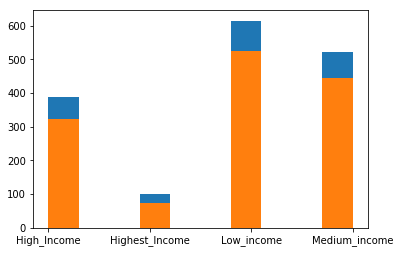

In [122]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_female_young[(df_comb_female_young.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_female_young[(df_comb_female_young.event =='transaction')]['quartile_income_c'])

In [123]:
print("female young")
df_comb_female_young[(df_comb_female_young.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_comb_female_young[(df_comb_female_young.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female young


quartile_income_c
Low_income        0.855049
Medium_income     0.852207
High_Income       0.832474
Highest_Income    0.750000
Name: quartile_income_c, dtype: float64

((array([ 659.,    0.,    0.,  914.,    0.,    0.,  316.,    0.,    0.,  534.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 465.,    0.,    0.,  631.,    0.,    0.,  273.,    0.,    0.,  422.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

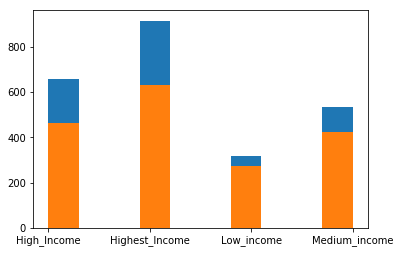

In [124]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_female_middle[(df_comb_female_middle.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_female_middle[(df_comb_female_middle.event =='transaction')]['quartile_income_c'])

In [125]:
print("female middle")
df_comb_female_middle[(df_comb_female_middle.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_comb_female_middle[(df_comb_female_middle.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female middle


quartile_income_c
Low_income        0.863924
Medium_income     0.790262
High_Income       0.705615
Highest_Income    0.690372
Name: quartile_income_c, dtype: float64

((array([  598.,     0.,     0.,  1042.,     0.,     0.,   251.,     0.,
             0.,   483.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 430.,    0.,    0.,  712.,    0.,    0.,  197.,    0.,    0.,  355.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

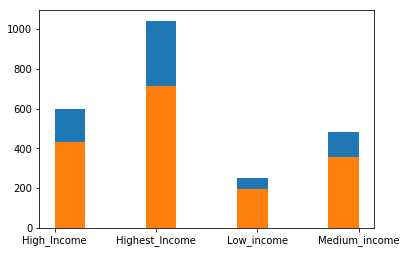

In [126]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_female_old[(df_comb_female_old.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_female_old[(df_comb_female_old.event =='transaction')]['quartile_income_c'])

In [127]:
print("female old")
df_comb_female_old[(df_comb_female_old.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_comb_female_old[(df_comb_female_old.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female old


quartile_income_c
Low_income        0.784861
Medium_income     0.734990
High_Income       0.719064
Highest_Income    0.683301
Name: quartile_income_c, dtype: float64

((array([  710.,     0.,     0.,  1206.,     0.,     0.,   335.,     0.,
             0.,   472.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 499.,    0.,    0.,  818.,    0.,    0.,  280.,    0.,    0.,  354.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

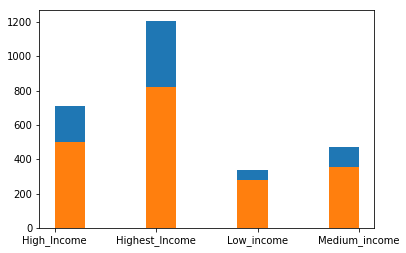

In [128]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_female_oldest[(df_comb_female_oldest.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_female_oldest[(df_comb_female_oldest.event =='transaction')]['quartile_income_c'])

In [129]:
print("female oldest")
df_comb_female_oldest[(df_comb_female_oldest.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_comb_female_oldest[(df_comb_female_oldest.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female oldest


quartile_income_c
Low_income        0.835821
Medium_income     0.750000
High_Income       0.702817
Highest_Income    0.678275
Name: quartile_income_c, dtype: float64

# Discount

In [130]:
df_comb_discount = df_comb5[(df_comb5.offer_type == 'discount')]
df_comb_discount.shape

(32356, 24)

In [131]:
# the count of offers viewed and offers completed
len(df_comb_discount[(df_comb_discount.event =='offer viewed')]), len(df_comb_discount[(df_comb_discount.event =='transaction')])

(18461, 13895)

# Distributions Overall for Discount

((array([ 4999.,     0.,     0.,  4746.,     0.,     0.,  4663.,     0.,
             0.,  4053.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 3665.,     0.,     0.,  3467.,     0.,     0.,  3410.,     0.,
             0.,  3353.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

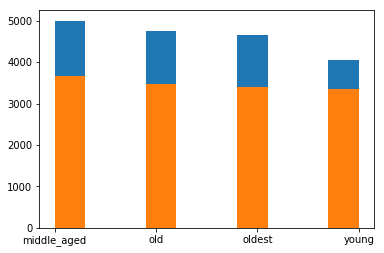

In [132]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_discount[(df_comb_discount.event =='offer viewed')]['quartile_age_c']), plt.hist(df_comb_discount[(df_comb_discount.event =='transaction')]['quartile_age_c'])

((array([  7733.,      0.,      0.,      0.,      0.,  10431.,      0.,
              0.,      0.,    297.]),
  array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
  <a list of 10 Patch objects>),
 (array([ 5827.,     0.,     0.,     0.,     0.,  7855.,     0.,     0.,
             0.,   213.]),
  array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
  <a list of 10 Patch objects>))

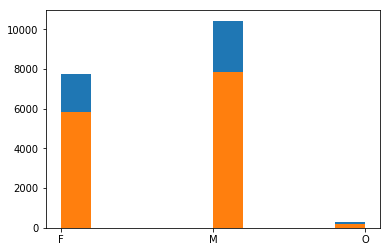

In [133]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_discount[(df_comb_discount.event =='offer viewed')]['gender']), plt.hist(df_comb_discount[(df_comb_discount.event =='transaction')]['gender'])

((array([ 4876.,     0.,     0.,  5114.,     0.,     0.,  3875.,     0.,
             0.,  4596.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 3658.,     0.,     0.,  3555.,     0.,     0.,  3216.,     0.,
             0.,  3466.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

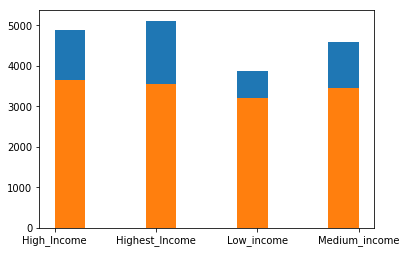

In [134]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_discount[(df_comb_discount.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_discount[(df_comb_discount.event =='transaction')]['quartile_income_c'])

In [135]:
# create 8 datasets for each group of individuals
df_disc_male_young = df_comb_discount[(df_comb_discount['gender']=='M') & (df_comb_discount['quartile_age_c']=='young')]
df_disc_male_middle = df_comb_discount[(df_comb_discount['gender']=='M') & (df_comb_discount['quartile_age_c']=='middle_aged')]
df_disc_male_old = df_comb_discount[(df_comb_discount['gender']=='M') & (df_comb_discount['quartile_age_c']=='old')]
df_disc_male_oldest = df_comb_discount[(df_comb_discount['gender']=='M') & (df_comb_discount['quartile_age_c']=='oldest')]

df_disc_female_young = df_comb_discount[(df_comb_discount['gender']=='F') & (df_comb_discount['quartile_age_c']=='young')]
df_disc_female_middle = df_comb_discount[(df_comb_discount['gender']=='F') & (df_comb_discount['quartile_age_c']=='middle_aged')]
df_disc_female_old = df_comb_discount[(df_comb_discount['gender']=='F') & (df_comb_discount['quartile_age_c']=='old')]
df_disc_female_oldest = df_comb_discount[(df_comb_discount['gender']=='F') & (df_comb_discount['quartile_age_c']=='oldest')]

In [136]:
df_disc_female_young.groupby(['event'])['event'].count()

event
offer viewed    1253
transaction     1063
Name: event, dtype: int64

# Distributions by Male

((array([  664.,     0.,     0.,   144.,     0.,     0.,  1137.,     0.,
             0.,   801.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 543.,    0.,    0.,   97.,    0.,    0.,  951.,    0.,    0.,  660.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

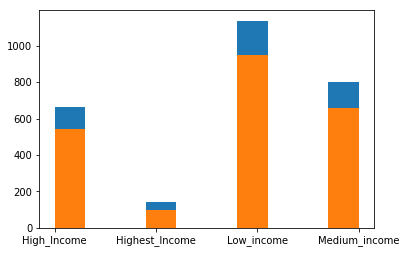

In [137]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_disc_male_young[(df_disc_male_young.event =='offer viewed')]['quartile_income_c']), plt.hist(df_disc_male_young[(df_disc_male_young.event =='transaction')]['quartile_income_c'])

In [138]:
print("male young")
df_disc_male_young[(df_disc_male_young.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_disc_male_young[(df_disc_male_young.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male young


quartile_income_c
Low_income        0.836412
Medium_income     0.823970
High_Income       0.817771
Highest_Income    0.673611
Name: quartile_income_c, dtype: float64

((array([ 793.,    0.,    0.,  626.,    0.,    0.,  632.,    0.,    0.,  802.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 594.,    0.,    0.,  422.,    0.,    0.,  512.,    0.,    0.,  577.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

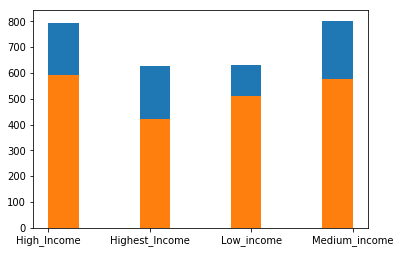

In [139]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_disc_male_middle[(df_disc_male_middle.event =='offer viewed')]['quartile_income_c']), plt.hist(df_disc_male_middle[(df_disc_male_middle.event =='transaction')]['quartile_income_c'])

In [140]:
print("male middle")
df_disc_male_middle[(df_disc_male_middle.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_disc_male_middle[(df_disc_male_middle.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male middle


quartile_income_c
Low_income        0.810127
Medium_income     0.719451
High_Income       0.749054
Highest_Income    0.674121
Name: quartile_income_c, dtype: float64

((array([ 657.,    0.,    0.,  731.,    0.,    0.,  490.,    0.,    0.,  602.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 466.,    0.,    0.,  485.,    0.,    0.,  397.,    0.,    0.,  433.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

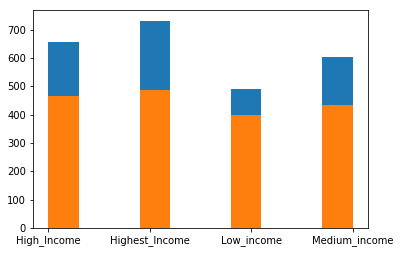

In [141]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_disc_male_old[(df_disc_male_old.event =='offer viewed')]['quartile_income_c']), plt.hist(df_disc_male_old[(df_disc_male_old.event =='transaction')]['quartile_income_c'])

In [142]:
print("male old")
df_disc_male_old[(df_disc_male_old.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_disc_male_old[(df_disc_male_old.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male old


quartile_income_c
Low_income        0.810204
Medium_income     0.719269
High_Income       0.709285
Highest_Income    0.663475
Name: quartile_income_c, dtype: float64

((array([ 600.,    0.,    0.,  701.,    0.,    0.,  434.,    0.,    0.,  617.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 428.,    0.,    0.,  486.,    0.,    0.,  360.,    0.,    0.,  444.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

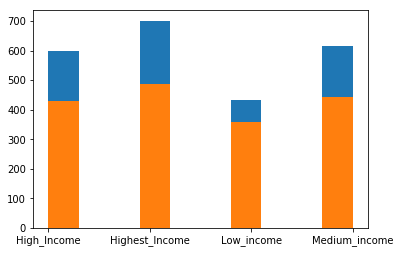

In [143]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_disc_male_oldest[(df_disc_male_oldest.event =='offer viewed')]['quartile_income_c']), plt.hist(df_disc_male_oldest[(df_disc_male_oldest.event =='transaction')]['quartile_income_c'])

In [144]:
print("male oldest")
df_disc_male_oldest[(df_disc_male_oldest.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_disc_male_oldest[(df_disc_male_oldest.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male oldest


quartile_income_c
Low_income        0.829493
Medium_income     0.719611
High_Income       0.713333
Highest_Income    0.693295
Name: quartile_income_c, dtype: float64

# Female

((array([ 320.,    0.,    0.,   88.,    0.,    0.,  432.,    0.,    0.,  413.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 274.,    0.,    0.,   69.,    0.,    0.,  379.,    0.,    0.,  341.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

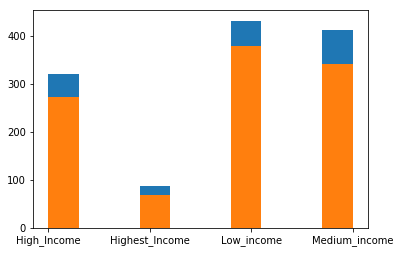

In [145]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_disc_female_young[(df_disc_female_young.event =='offer viewed')]['quartile_income_c']), plt.hist(df_disc_female_young[(df_disc_female_young.event =='transaction')]['quartile_income_c'])

In [146]:
print("female young")
df_disc_female_young[(df_disc_female_young.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_disc_female_young[(df_disc_female_young.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female young


quartile_income_c
Low_income        0.877315
Medium_income     0.825666
High_Income       0.856250
Highest_Income    0.784091
Name: quartile_income_c, dtype: float64

((array([ 576.,    0.,    0.,  770.,    0.,    0.,  217.,    0.,    0.,  493.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 409.,    0.,    0.,  533.,    0.,    0.,  172.,    0.,    0.,  383.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

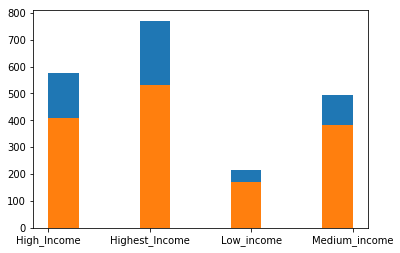

In [147]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_disc_female_middle[(df_disc_female_middle.event =='offer viewed')]['quartile_income_c']), plt.hist(df_disc_female_middle[(df_disc_female_middle.event =='transaction')]['quartile_income_c'])

In [148]:
print("female middle")
df_disc_female_middle[(df_disc_female_middle.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_disc_female_middle[(df_disc_female_middle.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female middle


quartile_income_c
Low_income        0.792627
Medium_income     0.776876
High_Income       0.710069
Highest_Income    0.692208
Name: quartile_income_c, dtype: float64

((array([ 597.,    0.,    0.,  939.,    0.,    0.,  223.,    0.,    0.,  422.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 454.,    0.,    0.,  680.,    0.,    0.,  185.,    0.,    0.,  306.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

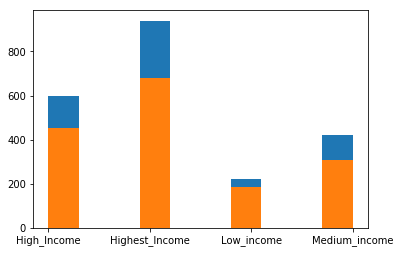

In [149]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_disc_female_old[(df_disc_female_old.event =='offer viewed')]['quartile_income_c']), plt.hist(df_disc_female_old[(df_disc_female_old.event =='transaction')]['quartile_income_c'])

In [150]:
print("female old")
df_disc_female_old[(df_disc_female_old.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_disc_female_old[(df_disc_female_old.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female old


quartile_income_c
Low_income        0.829596
Medium_income     0.725118
High_Income       0.760469
Highest_Income    0.724175
Name: quartile_income_c, dtype: float64

((array([  585.,     0.,     0.,  1029.,     0.,     0.,   255.,     0.,
             0.,   374.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 423.,    0.,    0.,  729.,    0.,    0.,  214.,    0.,    0.,  276.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

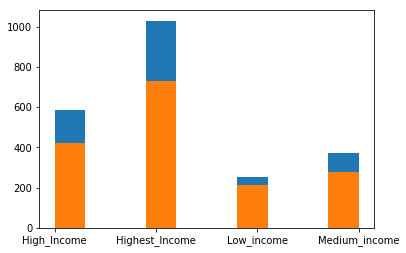

In [151]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_disc_female_oldest[(df_disc_female_oldest.event =='offer viewed')]['quartile_income_c']), plt.hist(df_disc_female_oldest[(df_disc_female_oldest.event =='transaction')]['quartile_income_c'])

In [152]:
print("female oldest")
df_disc_female_oldest[(df_disc_female_oldest.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_disc_female_oldest[(df_disc_female_oldest.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female oldest


quartile_income_c
Low_income        0.839216
Medium_income     0.737968
High_Income       0.723077
Highest_Income    0.708455
Name: quartile_income_c, dtype: float64

# Informational

In [153]:
df_comb_informational = df_comb5[(df_comb5.offer_type == 'informational')]

In [154]:
df_comb_informational.shape

(15648, 24)

In [155]:
df_comb_informational

,event,id,time,age,became_member_on,gender,income,amount,reward_x,offer_id,...,email,mobile,social,web,quartile_income_c,quartile_income_n,quartile_age_c,quartile_age_n,offer_response_flag,offer_not_viewed_flag
68958,offer viewed,0009655768c64bdeb2e877511632db8f,192,33,20170421,M,72000.0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,...,1.0,1.0,1.0,0.0,High_Income,"(62000.0, 78000.0]",young,"(17.999, 41.0]",0,0
79398,transaction,0009655768c64bdeb2e877511632db8f,228,33,20170421,M,72000.0,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,...,NaN,NaN,NaN,NaN,High_Income,"(62000.0, 78000.0]",young,"(17.999, 41.0]",1,0
124382,offer viewed,0009655768c64bdeb2e877511632db8f,372,33,20170421,M,72000.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,...,1.0,1.0,0.0,1.0,High_Income,"(62000.0, 78000.0]",young,"(17.999, 41.0]",0,0
14090,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,6,40,20180109,O,57000.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,...,1.0,1.0,0.0,1.0,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",0,0
42525,transaction,0011e0d4e6b944f998e987f904e8c1e5,132,40,20180109,O,57000.0,13.49,NaN,3f207df678b143eea3cee63160fa8bed,...,NaN,NaN,NaN,NaN,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",1,0
118466,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,354,40,20180109,O,57000.0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,...,1.0,1.0,1.0,0.0,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",0,0
260965,offer viewed,0020c2b971eb4e9188eac86d93036a77,660,59,20160304,F,90000.0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,...,1.0,1.0,1.0,0.0,Highest_Income,"(78000.0, 120000.0]",old,"(55.0, 66.0]",0,0
268808,transaction,0020c2b971eb4e9188eac86d93036a77,696,59,20160304,F,90000.0,27.94,NaN,5a8bc65990b245e5a138643cd4eb9837,...,NaN,NaN,NaN,NaN,Highest_Income,"(78000.0, 120000.0]",old,"(55.0, 66.0]",1,0
146910,offer viewed,0020ccbbb6d84e358d3414a3ff76cffd,408,24,20161111,F,60000.0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,...,1.0,1.0,1.0,0.0,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",0,0
156129,transaction,0020ccbbb6d84e358d3414a3ff76cffd,426,24,20161111,F,60000.0,8.93,NaN,5a8bc65990b245e5a138643cd4eb9837,...,NaN,NaN,NaN,NaN,Medium_income,"(48000.0, 62000.0]",young,"(17.999, 41.0]",1,0


In [156]:
# the count of offers viewed and offers completed
len(df_comb_informational[(df_comb_informational.event =='offer received')]), len(df_comb_informational[(df_comb_informational.event =='offer viewed')]), len(df_comb_informational[(df_comb_informational.event =='transaction')])

(0, 9360, 6288)

# Distributions Overall for Informational

((array([ 2669.,     0.,     0.,  2260.,     0.,     0.,  2337.,     0.,
             0.,  2094.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 1743.,     0.,     0.,  1477.,     0.,     0.,  1525.,     0.,
             0.,  1543.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

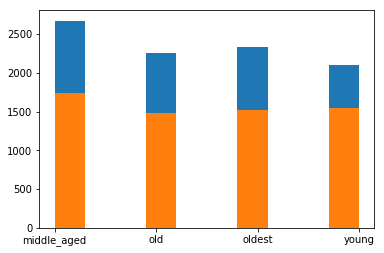

In [157]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_informational[(df_comb_informational.event =='offer viewed')]['quartile_age_c']), plt.hist(df_comb_informational[(df_comb_informational.event =='transaction')]['quartile_age_c'])

((array([ 3910.,     0.,     0.,     0.,     0.,  5289.,     0.,     0.,
             0.,   161.]),
  array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
  <a list of 10 Patch objects>),
 (array([ 2557.,     0.,     0.,     0.,     0.,  3630.,     0.,     0.,
             0.,   101.]),
  array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
  <a list of 10 Patch objects>))

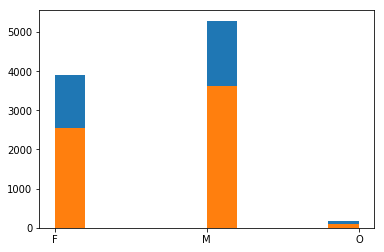

In [158]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_informational[(df_comb_informational.event =='offer viewed')]['gender']), plt.hist(df_comb_informational[(df_comb_informational.event =='transaction')]['gender'])

((array([ 2475.,     0.,     0.,  2413.,     0.,     0.,  2035.,     0.,
             0.,  2437.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 1673.,     0.,     0.,  1396.,     0.,     0.,  1539.,     0.,
             0.,  1680.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

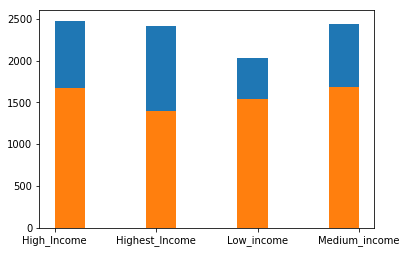

In [159]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_comb_informational[(df_comb_informational.event =='offer viewed')]['quartile_income_c']), plt.hist(df_comb_informational[(df_comb_informational.event =='transaction')]['quartile_income_c'])

In [160]:
# create 8 datasets for each group of individuals
df_info_male_young = df_comb_informational[(df_comb_informational['gender']=='M') & (df_comb_informational['quartile_age_c']=='young')]
df_info_male_middle = df_comb_informational[(df_comb_informational['gender']=='M') & (df_comb_informational['quartile_age_c']=='middle_aged')]
df_info_male_old = df_comb_informational[(df_comb_informational['gender']=='M') & (df_comb_informational['quartile_age_c']=='old')]
df_info_male_oldest = df_comb_informational[(df_comb_informational['gender']=='M') & (df_comb_informational['quartile_age_c']=='oldest')]

df_info_female_young = df_comb_informational[(df_comb_informational['gender']=='F') & (df_comb_informational['quartile_age_c']=='young')]
df_info_female_middle = df_comb_informational[(df_comb_informational['gender']=='F') & (df_comb_informational['quartile_age_c']=='middle_aged')]
df_info_female_old = df_comb_informational[(df_comb_informational['gender']=='F') & (df_comb_informational['quartile_age_c']=='old')]
df_info_female_oldest = df_comb_informational[(df_comb_informational['gender']=='F') & (df_comb_informational['quartile_age_c']=='oldest')]

# Distributions by Male

((array([ 351.,    0.,    0.,   60.,    0.,    0.,  587.,    0.,    0.,  392.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 254.,    0.,    0.,   31.,    0.,    0.,  445.,    0.,    0.,  287.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

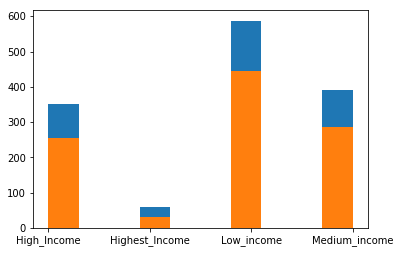

In [161]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_info_male_young[(df_info_male_young.event =='offer viewed')]['quartile_income_c']), plt.hist(df_info_male_young[(df_info_male_young.event =='transaction')]['quartile_income_c'])

In [162]:
print("male young")
df_info_male_young[(df_info_male_young.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_info_male_young[(df_info_male_young.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male young


quartile_income_c
Low_income        0.758092
Medium_income     0.732143
High_Income       0.723647
Highest_Income    0.516667
Name: quartile_income_c, dtype: float64

((array([ 404.,    0.,    0.,  319.,    0.,    0.,  333.,    0.,    0.,  451.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 273.,    0.,    0.,  176.,    0.,    0.,  245.,    0.,    0.,  298.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

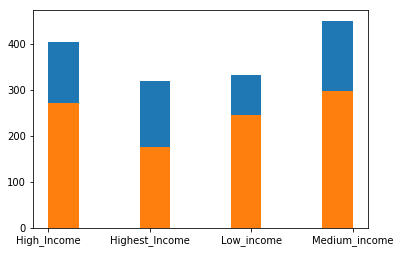

In [163]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_info_male_middle[(df_info_male_middle.event =='offer viewed')]['quartile_income_c']), plt.hist(df_info_male_middle[(df_info_male_middle.event =='transaction')]['quartile_income_c'])

In [164]:
print("male middle")
df_info_male_middle[(df_info_male_middle.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_info_male_middle[(df_info_male_middle.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male middle


quartile_income_c
Low_income        0.735736
Medium_income     0.660754
High_Income       0.675743
Highest_Income    0.551724
Name: quartile_income_c, dtype: float64

((array([ 319.,    0.,    0.,  314.,    0.,    0.,  269.,    0.,    0.,  306.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 213.,    0.,    0.,  190.,    0.,    0.,  196.,    0.,    0.,  218.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

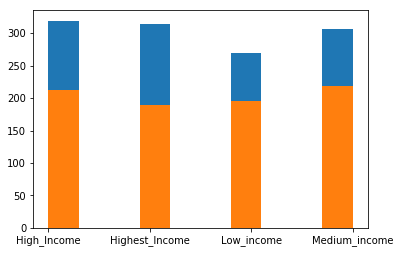

In [165]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_info_male_old[(df_info_male_old.event =='offer viewed')]['quartile_income_c']), plt.hist(df_info_male_old[(df_info_male_old.event =='transaction')]['quartile_income_c'])

In [166]:
print("male old")
df_info_male_old[(df_info_male_old.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_info_male_old[(df_info_male_old.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male old


quartile_income_c
Low_income        0.728625
Medium_income     0.712418
High_Income       0.667712
Highest_Income    0.605096
Name: quartile_income_c, dtype: float64

((array([ 291.,    0.,    0.,  340.,    0.,    0.,  221.,    0.,    0.,  332.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 197.,    0.,    0.,  208.,    0.,    0.,  170.,    0.,    0.,  229.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

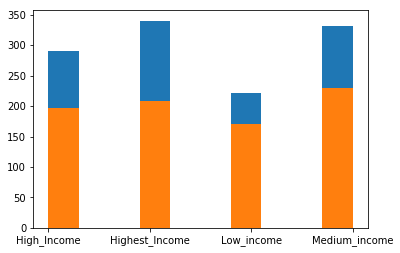

In [167]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_info_male_oldest[(df_info_male_oldest.event =='offer viewed')]['quartile_income_c']), plt.hist(df_info_male_oldest[(df_info_male_oldest.event =='transaction')]['quartile_income_c'])

In [168]:
print("male oldest")
df_info_male_oldest[(df_info_male_oldest.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_info_male_oldest[(df_info_male_oldest.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

male oldest


quartile_income_c
Low_income        0.769231
Medium_income     0.689759
High_Income       0.676976
Highest_Income    0.611765
Name: quartile_income_c, dtype: float64

# Female

((array([ 170.,    0.,    0.,   51.,    0.,    0.,  235.,    0.,    0.,  218.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 117.,    0.,    0.,   41.,    0.,    0.,  189.,    0.,    0.,  159.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

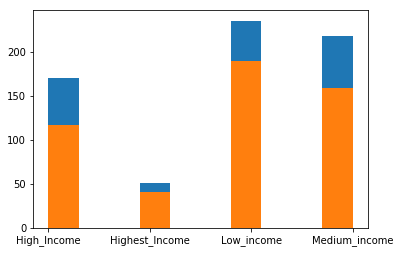

In [169]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_info_female_young[(df_info_female_young.event =='offer viewed')]['quartile_income_c']), plt.hist(df_info_female_young[(df_info_female_young.event =='transaction')]['quartile_income_c'])

In [170]:
print("female young")
df_info_female_young[(df_info_female_young.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_info_female_young[(df_info_female_young.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female young


quartile_income_c
Low_income        0.804255
Medium_income     0.729358
High_Income       0.688235
Highest_Income    0.803922
Name: quartile_income_c, dtype: float64

((array([ 331.,    0.,    0.,  380.,    0.,    0.,  130.,    0.,    0.,  269.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 217.,    0.,    0.,  224.,    0.,    0.,   87.,    0.,    0.,  191.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

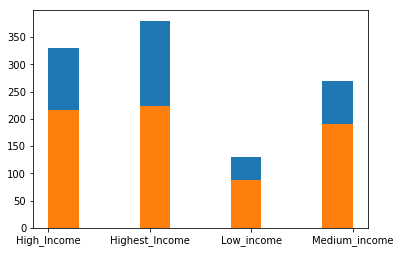

In [171]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_info_female_middle[(df_info_female_middle.event =='offer viewed')]['quartile_income_c']), plt.hist(df_info_female_middle[(df_info_female_middle.event =='transaction')]['quartile_income_c'])

In [172]:
print("female middle")
df_info_female_middle[(df_info_female_middle.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_info_female_middle[(df_info_female_middle.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female middle


quartile_income_c
Low_income        0.669231
Medium_income     0.710037
High_Income       0.655589
Highest_Income    0.589474
Name: quartile_income_c, dtype: float64

((array([ 271.,    0.,    0.,  420.,    0.,    0.,   95.,    0.,    0.,  227.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 183.,    0.,    0.,  231.,    0.,    0.,   72.,    0.,    0.,  151.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

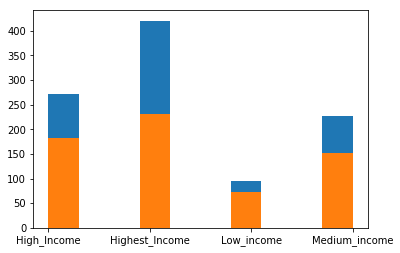

In [173]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_info_female_old[(df_info_female_old.event =='offer viewed')]['quartile_income_c']), plt.hist(df_info_female_old[(df_info_female_old.event =='transaction')]['quartile_income_c'])

In [174]:
print("female old")
df_info_female_old[(df_info_female_old.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_info_female_old[(df_info_female_old.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female old


quartile_income_c
Low_income        0.757895
Medium_income     0.665198
High_Income       0.675277
Highest_Income    0.550000
Name: quartile_income_c, dtype: float64

((array([ 308.,    0.,    0.,  473.,    0.,    0.,  133.,    0.,    0.,  199.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>),
 (array([ 203.,    0.,    0.,  259.,    0.,    0.,  107.,    0.,    0.,  126.]),
  array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
  <a list of 10 Patch objects>))

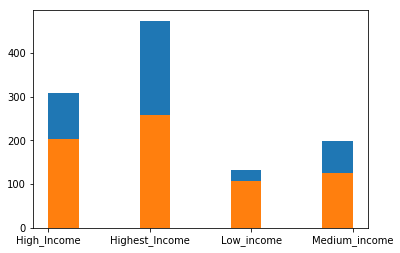

In [175]:
# the blue represents the total length of the bar which is "offer viewed" while the orange is "offer completed" which is a percentage of the blue bar
plt.hist(df_info_female_oldest[(df_info_female_oldest.event =='offer viewed')]['quartile_income_c']), plt.hist(df_info_female_oldest[(df_info_female_oldest.event =='transaction')]['quartile_income_c'])

In [176]:
print("female oldest")
df_info_female_oldest[(df_info_female_oldest.event =='transaction')].groupby(['quartile_income_c'])['quartile_income_c'].count()/df_info_female_oldest[(df_info_female_oldest.event =='offer viewed')].groupby(['quartile_income_c'])['quartile_income_c'].count()

female oldest


quartile_income_c
Low_income        0.804511
Medium_income     0.633166
High_Income       0.659091
Highest_Income    0.547569
Name: quartile_income_c, dtype: float64